In [1]:
import pandas as pd
%pip install requests
import requests
# USGSから過去1か月の地震データを取得
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
response = requests.get(url)

# データをファイルに保存
with open('earthquakes.csv', 'wb') as file:
    file.write(response.content)

# データをDataFrameに読み込む
data = pd.read_csv('earthquakes.csv')

# データの最初の5行を表示
data.head(100)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/Users/kanbesouichirou/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-11-12T01:21:24.490Z,61.626200,-151.078200,67.100,1.60,ml,NaN,NaN,NaN,0.23,...,2025-11-12T01:22:38.234Z,"31 km WNW of Susitna, Alaska",earthquake,NaN,0.800,NaN,NaN,automatic,ak,ak
1,2025-11-12T01:19:31.519Z,62.737500,-148.625100,61.800,1.50,ml,NaN,NaN,NaN,1.24,...,2025-11-12T01:21:40.345Z,"74 km SSE of Cantwell, Alaska",earthquake,NaN,0.600,NaN,NaN,automatic,ak,ak
2,2025-11-12T01:16:46.960Z,59.544200,-152.242500,45.800,1.90,ml,NaN,NaN,NaN,0.32,...,2025-11-12T01:18:22.826Z,"27 km NW of Nanwalek, Alaska",earthquake,NaN,1.700,NaN,NaN,automatic,ak,ak
3,2025-11-12T01:01:18.220Z,33.161667,-116.180833,11.760,1.85,ml,16.0,208.0,0.22740,0.33,...,2025-11-12T01:05:05.395Z,"5 km WNW of Ocotillo Wells, CA",earthquake,2.69,25.660,0.344000,11.0,automatic,ci,ci
4,2025-11-12T00:56:04.150Z,33.981500,-116.650500,16.760,1.01,ml,43.0,33.0,0.05692,0.17,...,2025-11-12T00:59:31.356Z,"10 km SW of Morongo Valley, CA",earthquake,0.19,0.440,0.197000,28.0,automatic,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-11-11T12:03:08.148Z,39.550100,143.180500,31.707,4.60,mb,47.0,103.0,2.04000,0.63,...,2025-11-11T12:35:24.040Z,"106 km E of Yamada, Japan",earthquake,7.51,5.923,0.074000,55.0,reviewed,us,us
96,2025-11-11T11:46:29.330Z,37.543999,-118.853333,6.350,0.88,md,9.0,190.0,0.04982,0.02,...,2025-11-11T13:32:19.975Z,"15 km SE of Mammoth Lakes, CA",earthquake,1.24,2.530,0.110000,9.0,automatic,nc,nc
97,2025-11-11T11:41:45.260Z,62.418900,-151.539400,92.100,1.70,ml,NaN,NaN,NaN,0.73,...,2025-11-11T11:44:03.064Z,"40 km WSW of Petersville, Alaska",earthquake,NaN,0.700,NaN,NaN,automatic,ak,ak
98,2025-11-11T11:32:16.260Z,33.255667,-116.303000,9.190,0.60,ml,42.0,42.0,0.07505,0.20,...,2025-11-11T16:05:30.618Z,"7 km E of Borrego Springs, CA",earthquake,0.22,0.520,0.120000,10.0,reviewed,ci,ci


In [2]:
# 国ごとの地震発生頻度ランキングと最大マグニチュードランキングを作成し、合計ポイントで順位付け
# 地震データには国情報が直接含まれていないため、place列から国名を抽出
#str.split(",").str[-1]でカンマ区切りの最後の部分を国名として抽出
data["country"] = data["place"].str.split(",").str[-1]
# 国ごとの地震発生頻度ランキング作成
ranking = data["country"].value_counts().head(10)

# 頻度ランキングのデータフレーム化
ranking_df = ranking.reset_index()
ranking_df.columns = ["country", "count"]
# ランキングを1から始める
ranking_df.index += 1

# 頻度に基づくポイント付与（頻度が高いほど高ポイント）
# 頻度ランキングの順位を逆にしてポイントを計算
ranking_df["point"] = ranking_df["count"].rank(method="min", ascending=False).astype(int)
# 高い頻度に高いポイントを与えるために、最大ポイントから引く
ranking_df["point"] = ranking_df["point"].max() - ranking_df["point"] + 1

# 最大マグニチュードランキング作成
# 国ごとの最大マグニチュード上位10か国を抽出
ranking_mag = data.sort_values("mag", ascending=False)[["mag", "country"]].head(10)
ranking_mag = ranking_mag.reset_index(drop=True)
# ランキングを1から始める
ranking_mag.index += 1
# マグニチュードに基づくポイント付与（マグニチュードが高いほど高ポイント）
# 高いマグニチュードに高いポイントを与えるために、ランキングの逆順でポイントを計算
ranking_mag["point"] = ranking_mag.index.map(lambda x: 11 - x)

# 頻度ポイントとマグニチュードポイントを合算して最終ランキングを作成
# 外部結合で両方のポイントを結合
merged = pd.merge(ranking_df, ranking_mag[["country", "point"]], on="country", how="outer", suffixes=("_freq", "_mag"))

# 空白を0に置換
merged = merged.fillna(0)

# 合計ポイントを計算
merged["total_point"] = merged["point_freq"] + merged["point_mag"]

# 各国の最大マグニチュードを取得
max_mag_per_country = data.groupby("country")["mag"].max().reset_index()
# 列名を変更
max_mag_per_country.columns = ["country", "max_mag"]

# 最終ランキングに最大マグニチュードを追加
final_ranking = pd.merge(merged, max_mag_per_country, on="country", how="left")
# データ型を整数に変換
final_ranking["total_point"] = final_ranking["total_point"].astype(int)
final_ranking["point_freq"] = final_ranking["point_freq"].astype(int)
final_ranking["point_mag"] = final_ranking["point_mag"].astype(int)

# 合計ポイントで並び替え
final_ranking = final_ranking.sort_values("total_point", ascending=False).reset_index(drop=True)

# ランキングを1から始める
final_ranking.index += 1
# 最終ランキングの上位10か国を表示
print("\n\n=== 合計ポイント  頻度 + 最大マグニチュード ランキング ===\n")
print(final_ranking[["country", "count", "max_mag", "point_freq", "point_mag", "total_point"]].head(10))





=== 合計ポイント  頻度 + 最大マグニチュード ランキング ===

        country   count  max_mag  point_freq  point_mag  total_point
1            CA  2354.0     3.83          10          0           10
2         Japan     0.0     6.80           0         10           10
3    Guadeloupe     0.0     6.50           0          9            9
4        Alaska  1945.0     5.40           9          0            9
5         Texas   572.0     3.20           8          0            8
6     Indonesia     0.0     6.50           0          8            8
7         Japan     0.0     6.80           0          7            7
8    Washington   195.0     2.85           7          0            7
9        Hawaii   192.0     4.15           6          0            6
10    Banda Sea     0.0     6.40           0          6            6


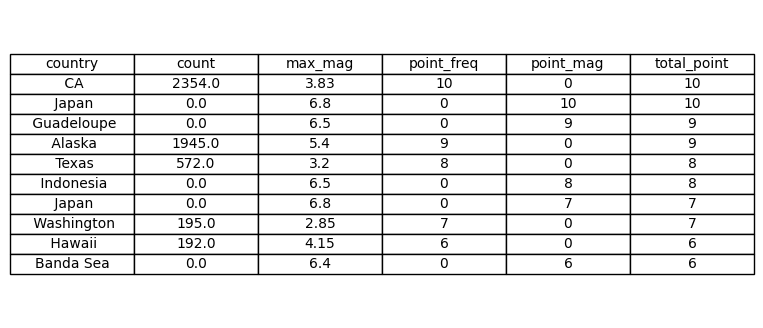

In [3]:
import matplotlib.pyplot as plt

# 表示したいデータ（上位10件だけ）
table_data = final_ranking[["country", "count", "max_mag", "point_freq", "point_mag", "total_point"]].head(10)

# 図を作成
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

# 表を作成
table = ax.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center')

# 表のスタイルを整える
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# 画像として保存
plt.savefig("ranking_table.png", bbox_inches='tight', dpi=300)
plt.show()
